# Дослідження набору даних. Виконання перетворень та очистки

In [1]:
import pandas as pd

df = pd.read_csv("Datasets/train_car_demand.csv")
df.info()

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18247 entries, 0 to 18246
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    18247 non-null  object
 1   hour    18247 non-null  int64 
 2   demand  18247 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 427.8+ KB


,date,hour,demand
0,2018-08-18,9,91
1,2018-08-18,10,21
2,2018-08-18,13,23
3,2018-08-18,14,104
4,2018-08-18,15,81


In [2]:
df['date'] = pd.to_datetime(df['date'])

df = df.groupby('date')['demand'].sum().reset_index()

df.head()

,date,demand
0,2018-08-18,632
1,2018-08-19,1040
2,2018-08-20,835
3,2018-08-21,932
4,2018-08-22,944


In [3]:
df.isnull().sum()

date      0
demand    0
dtype: int64

In [4]:
df.dropna()

,date,demand
0,2018-08-18,632
1,2018-08-19,1040
2,2018-08-20,835
3,2018-08-21,932
4,2018-08-22,944
...,...,...
890,2021-02-24,1659
891,2021-02-25,1417
892,2021-02-26,1812
893,2021-02-27,2165


<Axes: xlabel='date'>

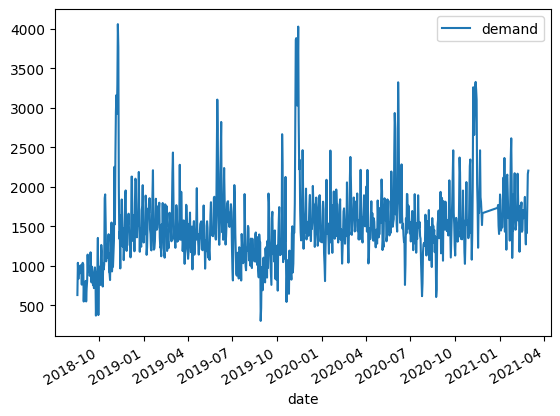

In [5]:
df.plot(x='date', y='demand')

In [6]:
df.loc[(df['date'] >= '2020-10-01') & (df['date'] <= '2021-01-01')]
# Розрив 2020-11-26 --> 2020-12-27

,date,demand
774,2020-10-01,1132
775,2020-10-02,1363
776,2020-10-03,1609
777,2020-10-04,1551
778,2020-10-05,1396
...,...,...
832,2020-12-28,1772
833,2020-12-29,1509
834,2020-12-30,1405
835,2020-12-31,1616


<Axes: xlabel='date'>

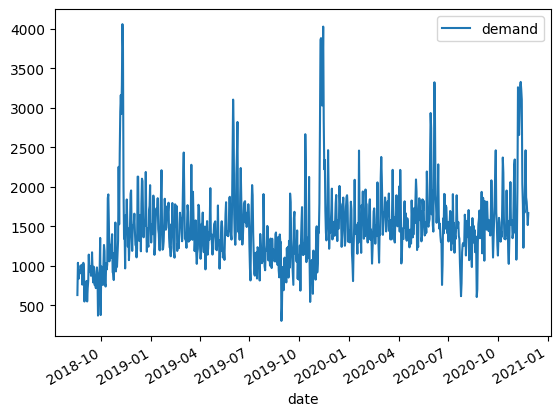

In [7]:
indices_to_drop = df[df['date'] > '2020-11-26'].index

df = df.drop(indices_to_drop)
df.plot(x='date', y='demand')

# Розділення даних на тренувальні та тестові

In [8]:
msk = (df.index < len(df)-30)
df_train = df[msk].copy()
df_test = df[~msk].copy()

# Графіки функції автокореляції (ACF) та часткової функції автокореляції (PACF)

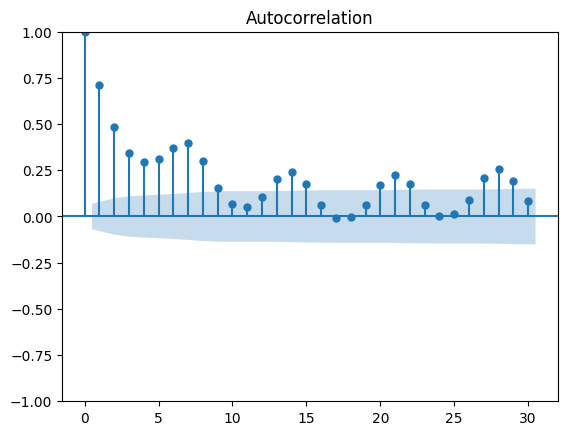

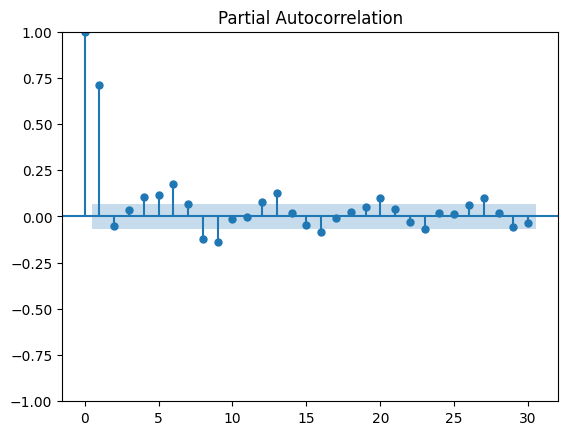

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(df_train['demand'])

pacf_original = plot_pacf(df_train['demand'])

# ADF тест

In [10]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df_train['demand'])
print(f'p-value: {adf_test[1]}')

p-value: 0.0001685924590897053


# Створення ARIMA моделі

In [11]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_train['demand'], order=(2, 0, 3))
model_fit = model.fit()

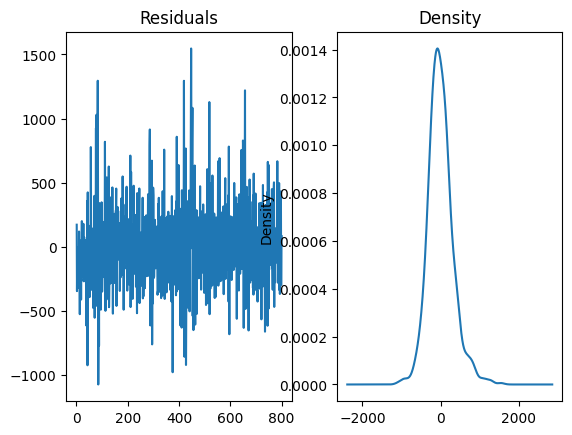

In [12]:
import matplotlib.pyplot as plt

residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1, 2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde' , ax=ax[1])
plt.show()

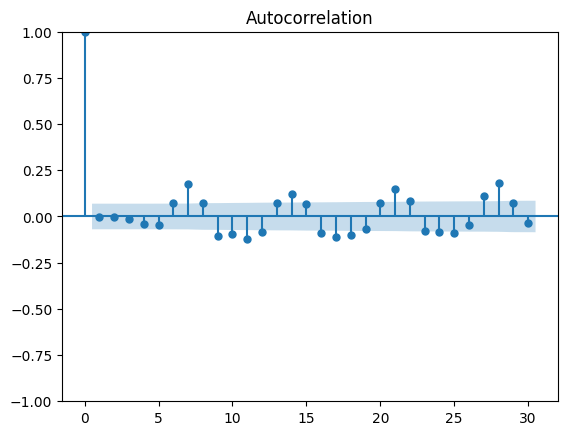

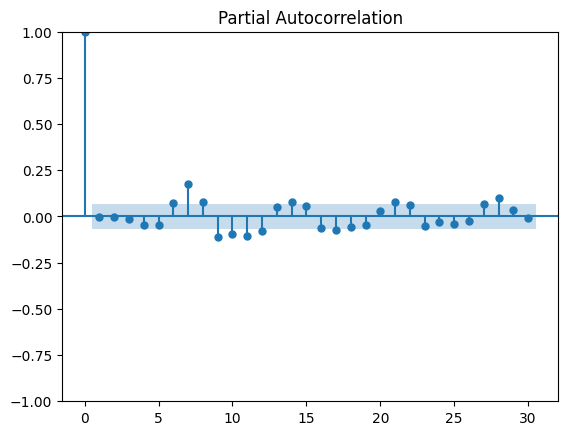

In [13]:
acf_res = plot_acf(residuals)
pacf_res = plot_pacf(residuals)

# Тестування створеної моделі

<Axes: xlabel='date'>

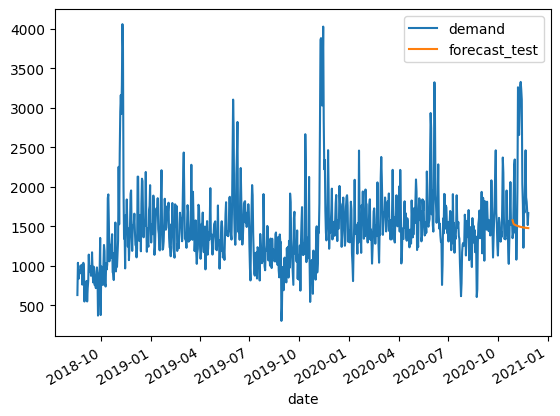

In [14]:
forecast_test = model_fit.forecast(len(df_test))
df['forecast_test'] = [None]*len(df_train) + list(forecast_test)

df.plot(x='date')

# Автоматичне створення моделі ARIMA

In [15]:
import pmdarima as pm
auto_arima = pm.auto_arima(df['demand'], stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(2, 1, 3), scoring_args={}, suppress_warnings=True)

# Тестування автоматично створеної моделі ARIMA

<Axes: xlabel='date'>

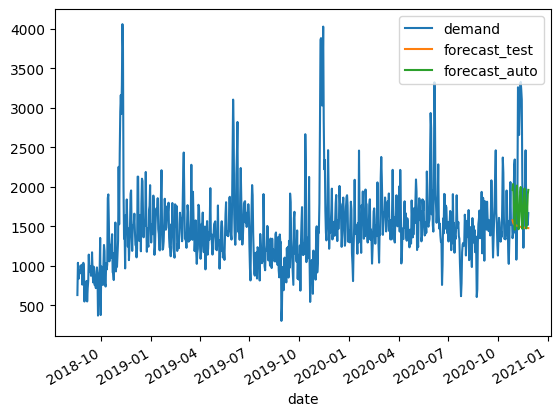

In [16]:
forecast_test_auto = auto_arima.predict(n_periods=len(df_test))
df['forecast_auto'] = [None]*len(df_train) + list(forecast_test_auto)

df.plot(x='date')